# Water Potability - Fractal DS Challange
In this challange we are given with chemical composition of the water samples and task is to predict whether the water is safe for drinking or not.  

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error, make_scorer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from warnings import filterwarnings

filterwarnings("ignore")

In [2]:
# Notebook Parameters
dataset_directory = "./d6eb5cd1b3b211ef/Dataset"
training_data_filename = "train.csv"
testing_data_filename = "test.csv"
output_directory = "./outputs"
device = ["cuda" if torch.cuda.is_available() else "cpu"][0]
epochs = 200
print("Device : ", device)

Device :  cpu


In [3]:
# Make the directory for storing output files.
os.makedirs(output_directory, exist_ok = True)

In [4]:
# Reading the input data files into dataframe.
train_df = pd.read_csv(os.path.join(dataset_directory, training_data_filename))
test_df = pd.read_csv(os.path.join(dataset_directory, testing_data_filename))

## Data Exploration

In [5]:
train_df.head()

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0,<p>😅The pH value observed is: 0.2644088544860...,<br>😒With a hardness level of 2.6735383052025...,<br>😅The water sample exhibits a total solids ...,1.431972,1.303685,1.563001,0.697062,2.010126,<h1>😀Observing a turbidity value of 1.60887258...,1.252351
1,1,<p>😇The solution's pH level is 0.012034498894...,<h1>😀The water hardness is measured at 2.6303...,<br>😒The total solids content in the sample is...,0.911372,1.181754,1.741640,0.896108,1.807786,<br>😁The water sample exhibits a turbidity rea...,1.124565
2,2,<br>😀The pH reading measures 0.491167423175516...,<h2>😅With a hardness level of 1.2213782428674...,<h1>😍The water sample exhibits a total solids ...,1.506492,1.700871,2.322337,1.035440,1.548768,<p>😇Observing a turbidity value of 1.008907465...,0.525886
3,3,<h1>😅The water sample's pH level is 0.4865531...,<h2>😀With a hardness level of 1.2591335755542...,<h1>😅The total solids content in the sample is...,2.658852,3.035266,2.409255,1.185713,1.232375,<p>😇The water sample exhibits a turbidity read...,0.715288
4,4,<p>😍The observed pH value of 0.07548804288855...,<p>😁With a hardness level of 1.65681755735377...,<p>😍The total solids content in the sample is ...,2.169616,1.520531,1.990604,1.237182,1.589307,<h1>😒The water sample exhibits a turbidity rea...,0.890722


In [6]:
train_df.tail()

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
9995,9995,<br>😍The observed pH value of 0.0666474523593...,<h1>😒The water hardness is measured at 1.2914...,<p>😅The water sample exhibits a total solids r...,1.980678,2.129723,1.629682,1.228212,1.401602,<br>😇Observing a turbidity value of 1.39864509...,1.003687
9996,9996,<p>😀The observed pH value of 0.87789992053641...,<h2>😅The water hardness is measured at 2.4495...,<p>😇Observing a solids concentration of 1.389...,1.575261,3.389656,1.808995,0.984893,1.418192,<h2>😇The water sample exhibits a turbidity rea...,0.857710
9997,9997,<h1>😇The water sample's pH level is 0.0547191...,<p>😇The water hardness is measured at 1.10634...,<p>😁Observing a solids concentration of 2.180...,2.346026,1.471835,2.987930,2.089299,1.898912,<h2>😅The turbidity of the water is measured at...,1.369970
9998,9998,<h1>😒The solution's pH level is 0.86477809896...,<p>😒The observed water hardness of 2.56094707...,<br>😒Observing a solids concentration of 1.62...,1.347337,2.646122,1.684377,1.372873,1.685423,<p>😅Observing a turbidity value of 0.928453928...,0.821249
9999,9999,<p>😍The water sample's pH level is 0.69271759...,<p>😍The observed water hardness of 1.22437658...,<h2>😒The total solids content in the sample is...,1.533567,2.169574,2.990695,1.520676,2.325090,<br>😍The water sample exhibits a turbidity rea...,0.669703


In [7]:
test_df.head()

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,10000,<br>😒The observed pH value of 0.4583260930518...,<h1>😁The observed water hardness of 1.7903445...,<p>😁Observing a solids concentration of 1.573...,1.540880,1.659576,2.156778,1.665096,2.105437,<br>😅The turbidity of the water is measured at...
1,10001,<br>😀The pH value observed is: 0.006163832801...,<p>😁The observed water hardness of 2.37971669...,<h1>😒The total solids content in the sample is...,1.225821,1.320635,2.251759,1.333259,1.480757,<p>😅The water sample exhibits a turbidity read...
2,10002,<h2>😀The pH reading measures 0.682188913921691...,<h2>😇The observed water hardness of 1.4080275...,<p>😍The total solids content in the sample is ...,2.430112,1.178618,1.614353,0.890702,1.824291,<br>😀Observing a turbidity value of 1.11871445...
3,10003,<p>😀The observed pH value of 0.56282397372454...,<br>😀The observed water hardness of 1.8369703...,<h1>😍The total solids content in the sample is...,1.910825,2.731592,1.626107,0.711949,2.598104,<br>😍The turbidity of the water is measured at...
4,10004,<h1>😇The pH reading measures 0.336142283595807...,<h1>😀The water hardness is measured at 1.5104...,<br>😀Observing a solids concentration of 2.33...,1.940168,1.269851,1.832447,0.947763,1.052021,<h1>😁The water sample exhibits a turbidity rea...


In [8]:
test_df.tail()

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
4995,14995,<h2>😀The observed pH value of 0.6239939359130...,<br>😅The water hardness is measured at 1.1073...,<h2>😅The total solids content in the sample is...,2.506261,2.521742,2.431430,1.233360,1.432172,<h1>😁Observing a turbidity value of 0.74767882...
4996,14996,<p>😀The pH reading measures 0.7886902033415697...,<p>😁The water hardness is measured at 1.54095...,<h2>😅The total solids content in the sample is...,1.424656,1.669503,1.355871,1.346191,1.074413,<h2>😅The water sample exhibits a turbidity rea...
4997,14997,<br>😇The observed pH value of 0.1814957015634...,<h2>😇With a hardness level of 1.8477287606496...,<h2>😀The water sample exhibits a total solids ...,1.957594,2.402041,1.730559,0.870003,1.449529,<p>😁The water sample exhibits a turbidity read...
4998,14998,<br>😇The pH reading measures 0.074331335960389...,<br>😒The observed water hardness of 1.4081573...,<br>😅The water sample exhibits a total solids ...,1.260259,1.481893,2.762865,1.905638,2.912864,<p>😁The water sample exhibits a turbidity read...
4999,14999,<h2>😍The pH reading measures 0.582922252039877...,<h2>😅The observed water hardness of 1.2748626...,<p>😍The total solids content in the sample is ...,1.226636,1.810171,1.762686,0.772681,1.353406,<h1>😀The turbidity of the water is measured at...


## Observation
There are following columns which contains the readings in conjunction with comments:
<ul>
    <li>ph</li>
    <li>Hardness</li>
    <li>Solids</li>
    <li>Turbidity</li>
</ul>

As a preprocessing step we will need to extract the numeric values from the comments text present in above listed columns.

In [9]:
# Null Values check

train_df.isnull().sum()

Index              0
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [10]:
test_df.isnull().sum()

Index              0
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

## Observation
There are no rows with Null values in the data. 

## Data Cleaning

In [11]:
def strip_html_tags(text):
    if not isinstance(text, str):
        raise ValueError("Input must be a string")
    
    # Regular expression to remove HTML tags
    clean_text = re.sub(r'<[^>]*>', '', text)
    return clean_text

In [12]:
def extract_feature_value(text):
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    text = strip_html_tags(text)
    start_idx = 0
    while(not text[start_idx].isnumeric()):
        start_idx += 1
    end_idx = start_idx
    while(text[end_idx].isnumeric() or text[end_idx] == "."):
        end_idx += 1
    return float(text[start_idx : end_idx])

In [13]:
# Testing the function for cleaning.
extract_feature_value("<h2>ðŸ˜€With a hardness level of  1.2591335755542403  this water falls into the category of hard water.ðŸ˜€</h2>")

1.2591335755542403

In [14]:
comment_columns = ["ph", "Hardness", "Solids", "Turbidity"]

for column in comment_columns:
    train_df[column] = train_df[column].apply(lambda x : extract_feature_value(x))
    test_df[column] = test_df[column].apply(lambda x : extract_feature_value(x))

In [15]:
# Let's inspect the data post cleaning.
train_df.head()

,Index,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0,0.264409,2.673538,2.336743,1.431972,1.303685,1.563001,0.697062,2.010126,1.608873,1.252351
1,1,0.012034,2.630323,2.495853,0.911372,1.181754,1.741640,0.896108,1.807786,1.478430,1.124565
2,2,0.491167,1.221378,1.438038,1.506492,1.700871,2.322337,1.035440,1.548768,1.008907,0.525886
3,3,0.486553,1.259134,1.151006,2.658852,3.035266,2.409255,1.185713,1.232375,1.249935,0.715288
4,4,0.075488,1.656818,1.095344,2.169616,1.520531,1.990604,1.237182,1.589307,1.515182,0.890722


In [16]:
train_df.dtypes

Index                int64
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability         float64
dtype: object

In [17]:
test_df.dtypes

Index                int64
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
dtype: object

In [18]:
def plot_boxplots(df):
    num_columns = len(df.columns)
    
    # Create subplots with an appropriate grid size
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, 5 * num_columns))
    
    # Ensure axes is iterable if there's only one column
    if num_columns == 1:
        axes = [axes]

    for ax, column in zip(axes, df.columns):
        ax.boxplot(df[column].dropna(), vert=False)  # Plot horizontal box plot
        ax.set_title(f'Box Plot of {column}', fontsize=14)
        ax.set_xlabel('Value', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()

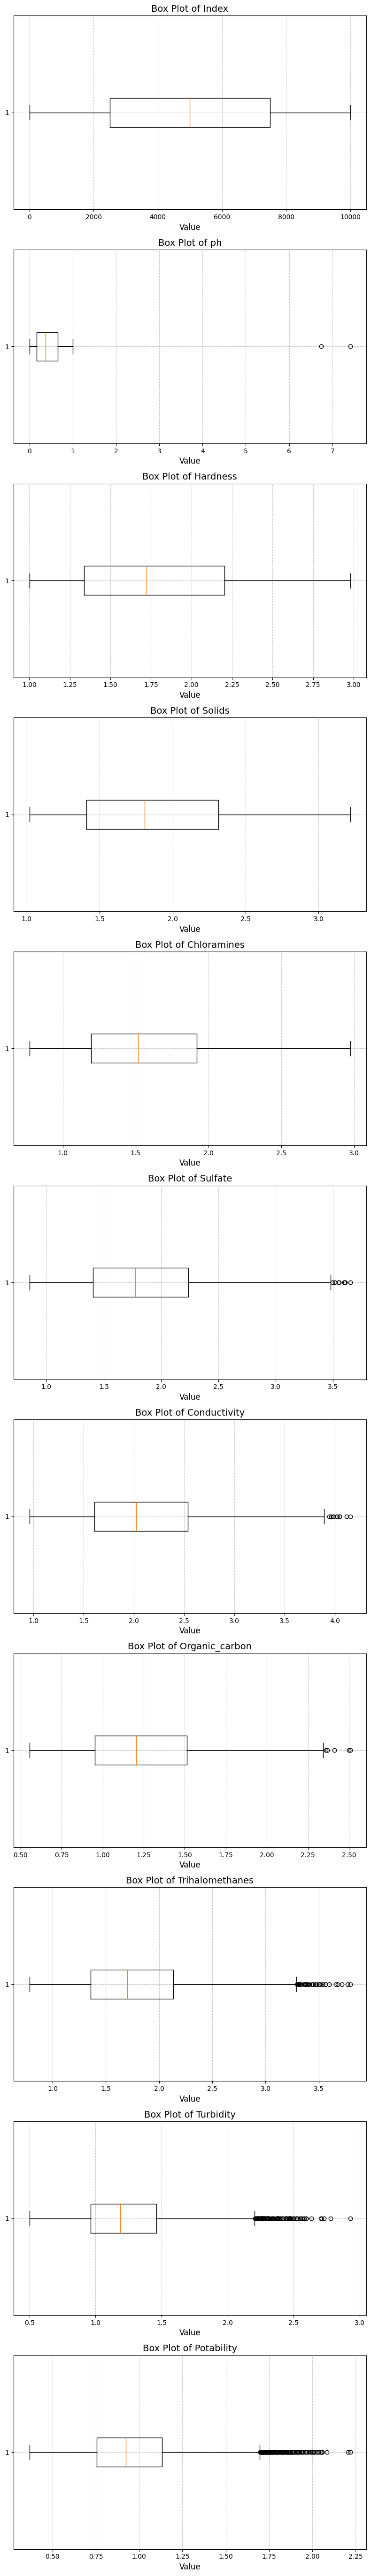

In [19]:
plot_boxplots(train_df)

## Observation
<ul>
    <li>ph column has a range of 0-1 and outliers exists near 7.</li>
    <li>Hardness column has a range of 1-3 and does not have any outliers.</li>
    <li>Solids column has a range of 1-3.5 and does not have any outliers.</li>
    <li>Chloramines column has a range of 0.5-3 and does not have any outliers.</li>
    <li>Sulphate column has a range of 0.5-3.5 and outliers exists above 3.5.</li>
    <li>Conductivity column has a range of 1-3.75 and outliers exists near 4.</li>
    <li>Organic_Carbon column has a range of 0.5-2.3 and outliers exists near 2.5.</li>
    <li>Trihalomethanes column has a range of 0.5-3.25 and outliers exists above 3.25.</li>
    <li>Turbidity column has a range of 0.5-2.25 and outliers exists above 2.25.</li>
</ul>

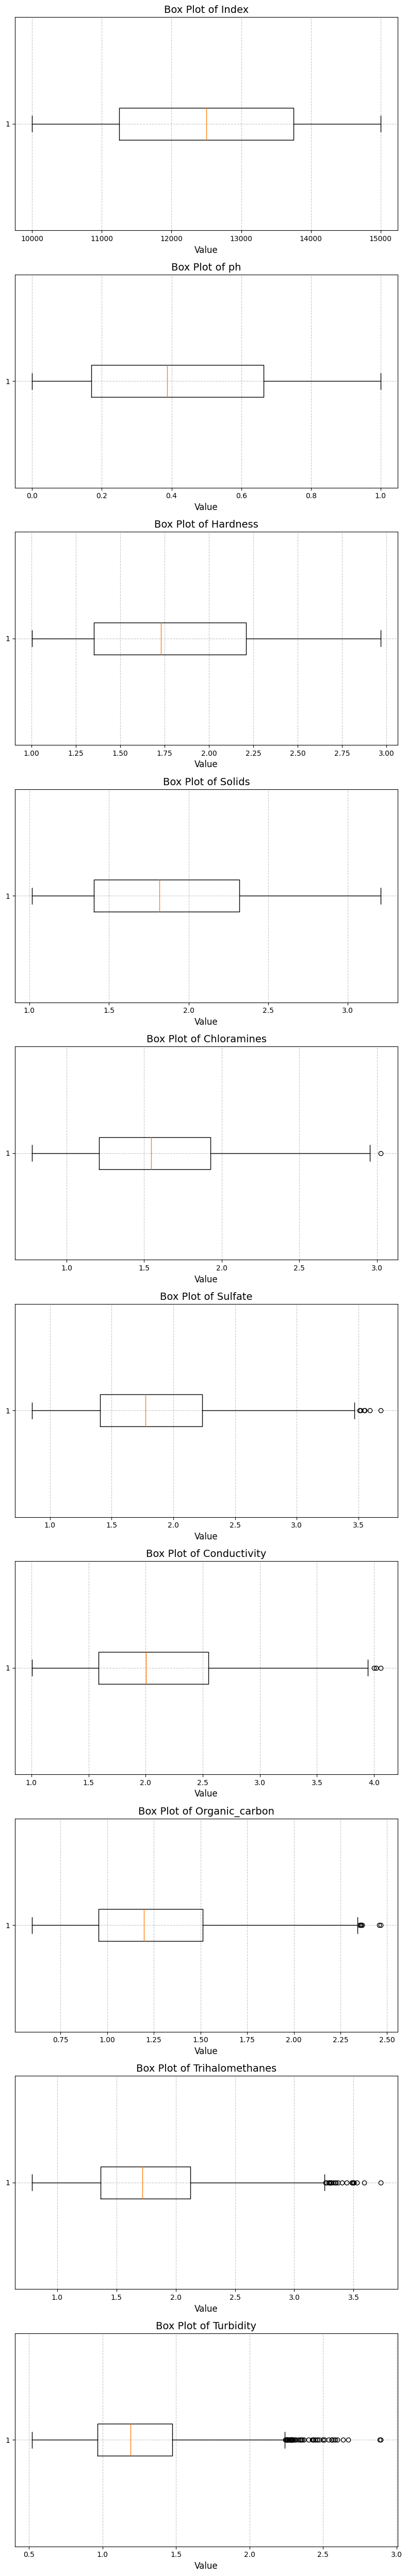

In [20]:
plot_boxplots(test_df)

## Observation
The distributions of data in test set is similar to that observed in training set.

## Model Iterations - Data Preperation

In [21]:
feature_columns = list(train_df.drop(columns = ["Index", "Potability"]).columns)
target_column = "Potability"

In [22]:
# Training-Validation split of the data
X_train, X_val, y_train, y_val = train_test_split(train_df[feature_columns], train_df[target_column], shuffle = True, test_size=0.2, random_state=42)

In [23]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8000, 9), (2000, 9), (8000,), (2000,))

In [24]:
# Standard Scaling
feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

X_train[feature_columns] = feature_scaler.fit_transform(X_train[feature_columns])
X_val[feature_columns] = feature_scaler.transform(X_val[feature_columns])
# y_train = target_scaler.fit_transform(y_train.to_numpy().reshape(-1,1)).reshape(-1)


X_test = test_df[feature_columns].copy(deep = True)
X_test[feature_columns] = feature_scaler.transform(X_test[feature_columns])

In [25]:
def metric(y_true, y_prediction):
    return max(0, 100 * (1 - median_absolute_error(y_true, y_prediction)))

In [26]:
def create_submission(df, predictions, filename = "submission.csv"):
    pd.DataFrame({
        "Index" : df["Index"].tolist(),
        "Potability" : predictions
    }).to_csv(os.path.join(output_directory, filename), index = False)

## Model Iteration - Model Training and Eval

In [27]:
model_lr = LinearRegression(n_jobs = -1)
model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_val)
print("Score : ", metric(y_val, predictions_lr))
# print("Score : ", metric(y_val, target_scaler.inverse_transform(predictions_lr.reshape(-1,1)).reshape(-1)))

Score :  85.04909835200868


In [28]:
predictions = model_lr.predict(X_test)
create_submission(test_df, predictions, filename = "submission_LR.csv")

In [29]:
model_xgb_base = XGBRegressor(n_jobs = -1)
model_xgb_base.fit(X_train, y_train)

predictions_xgb_base = model_xgb_base.predict(X_val)
print("Score : ", metric(y_val, predictions_xgb_base))
# print("Score : ", metric(y_val, target_scaler.inverse_transform(predictions_xgb_base.reshape(-1, 1)).reshape(-1)))

Score :  85.35126940793293


In [30]:
predictions = model_xgb_base.predict(X_test)
create_submission(test_df, predictions, filename = "submission_XGB_base.csv")

In [31]:
# Define the hyperparameter search space
search_space = {
    'n_estimators': hp.choice('n_estimators', range(50, 500, 50)),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

# Define the objective function
def objective(params):
    model = XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        random_state=42,
        n_jobs=-1
    )
    
    # Evaluate using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(metric, greater_is_better = True))
    mean_score = -1 * np.mean(scores)  # Convert to positive MSE
    return {'loss': mean_score, 'status': STATUS_OK}

# Run hyperparameter optimization
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,  # Number of iterations
    trials=trials,
    rstate=np.random.default_rng(42)  # Reproducibility
)

# Print the best parameters
print("Best hyperparameters:", best_params)

100%|█████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16trial/s, best loss: -85.4673026900938]
Best hyperparameters: {'colsample_bytree': 0.9911673917862088, 'gamma': 0.0867488991920963, 'learning_rate': 0.14224416541327592, 'max_depth': 0, 'n_estimators': 8, 'reg_alpha': 0.7306496126443225, 'reg_lambda': 0.3642082082714803, 'subsample': 0.809676702090579}


In [32]:
model_xgb_tuned = XGBRegressor(
    n_jobs = -1,
    **best_params
)
model_xgb_tuned.fit(X_train, y_train)

predictions_xgb_tuned = model_xgb_tuned.predict(X_val)
print("Score : ", metric(y_val, predictions_xgb_tuned))
# print("Score : ", metric(y_val, target_scaler.inverse_transform(predictions_xgb_tuned.reshape(-1, 1)).reshape(-1)))

Score :  83.97462344253044


In [33]:
predictions = model_xgb_tuned.predict(X_test)
create_submission(test_df, predictions, filename = "submission_XGB_tuned.csv")

In [34]:
# Ensemble Approach

best_alpha = 0.0
best_score = 0.0

for alpha in np.linspace(0, 1, num = 100):
    predictions_ensemble = alpha * predictions_lr + (1 - alpha) * predictions_xgb_base
    score = metric(y_val, predictions_ensemble)
    # score = metric(y_val, target_scaler.inverse_transform(predictions_ensemble.reshape(-1,1)).reshape(-1))
    if score > best_score:
        best_score = score
        best_alpha = alpha
print("Best Alpha : ", best_alpha, "\nBest Score : ", best_score)

Best Alpha :  0.13131313131313133 
Best Score :  85.52191864948387


In [35]:
predictions = best_alpha * model_lr.predict(X_test) + (1 - best_alpha) * model_xgb_base.predict(X_test)
create_submission(test_df, predictions, filename = "submission_XGB_Base_LR_ensemble.csv")

In [36]:
# Ensemble Approach

best_alpha = 0.0
best_score = 0.0

for alpha in np.linspace(0, 1, num = 100):
    predictions_ensemble = alpha * predictions_lr + (1 - alpha) * predictions_xgb_tuned
    score = metric(y_val, predictions_ensemble)
    # score = metric(y_val, target_scaler.inverse_transform(predictions_ensemble.reshape(-1,1)).reshape(-1))
    if score > best_score:
        best_score = score
        best_alpha = alpha
print("Best Alpha : ", best_alpha, "\nBest Score : ", best_score)

Best Alpha :  0.8484848484848485 
Best Score :  85.18500971810224


In [37]:
predictions = best_alpha * model_lr.predict(X_test) + (1 - best_alpha) * model_xgb_tuned.predict(X_test)
create_submission(test_df, predictions, filename = "submission_XGB_Tuned_LR_ensemble.csv")

In [41]:
# Pytorch Code 

class dataset:
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        if self.y is not None:
            return torch.tensor(self.X.iloc[idx], dtype = torch.float32), torch.tensor(self.y.iloc[idx].reshape(-1), dtype = torch.float32)
        else:
            return torch.tensor(self.X.iloc[idx], dtype = torch.float32)

train_dataset = dataset(X_train, y_train)
val_dataset = dataset(X_val, y_val)
test_dataset = dataset(X_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [42]:
class Model(nn.Module):
    def __init__(self, in_features, n_outputs = 1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features * 2)
        self.fc2 = nn.Linear(in_features * 2, in_features * 3)
        self.fc3 = nn.Linear(in_features * 3, in_features * 4)
        self.fc4 = nn.Linear(in_features * 4, in_features * 3)
        self.fc5 = nn.Linear(in_features * 3, in_features * 2)
        self.fc6 = nn.Linear(in_features * 2, n_outputs)

        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = nn.Dropout(0.2)(self.relu(self.fc2(x)))
        x = nn.Dropout(0.2)(self.relu(self.fc3(x)))
        x = nn.Dropout(0.2)(self.relu(self.fc4(x)))
        x = nn.Dropout(0.2)(self.relu(self.fc5(x)))
        x = self.relu(self.fc6(x))
        return x

model_mlp = Model(len(feature_columns)).to(device)

In [43]:
# Train Loop
optimizer = torch.optim.Adam(model_mlp.parameters(), lr = 1e-3)
criterion = nn.MSELoss()
patience = 3
monitor = patience
prev_loss = 1e+6

for epoch in range(epochs):
    if monitor <= 0:
        print("Early Stopping!")
        break
    train_running_loss = 0.0
    t_count = 0
    val_running_loss = 0.0
    v_count = 0
    val_predictions = []
    model_mlp.train()
    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model_mlp(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        t_count+=1
    model_mlp.eval()
    with torch.no_grad():
        for idx, (x, y) in enumerate(val_dataloader):
            x = x.to(device)
            y = y.to(device)
            predictions = model_mlp(x)
            loss = criterion(predictions, y)
            val_running_loss += loss.item()
            v_count+=1
            val_predictions.extend(predictions.detach().numpy().tolist())
    current_loss = val_running_loss / (64 * v_count)
    if prev_loss <= current_loss:
        monitor -= 1
    else:
        monitor = patience
    prev_loss = current_loss
    print(f"[Epoch = {epoch + 1}] Train Loss = {train_running_loss / (64 * t_count)} | Validation Loss = {val_running_loss / (64 * v_count)} | Val Score = {metric(y_val, np.array(val_predictions))}")
    
        

[Epoch = 1] Train Loss = 0.0034419708168134094 | Validation Loss = 0.001619799750187667 | Val Score = 79.64568424900791
[Epoch = 2] Train Loss = 0.0012510234890505672 | Validation Loss = 0.0011574086456676014 | Val Score = 82.1759831172397
[Epoch = 3] Train Loss = 0.0010029067164286972 | Validation Loss = 0.0009959724065993214 | Val Score = 82.86791323286697
[Epoch = 4] Train Loss = 0.0008873247951269149 | Validation Loss = 0.0008845224110700656 | Val Score = 84.05549287696365
[Epoch = 5] Train Loss = 0.0008346298295073212 | Validation Loss = 0.0008985743097582599 | Val Score = 84.30221038469257
[Epoch = 6] Train Loss = 0.0007812499438878148 | Validation Loss = 0.0008103631225822028 | Val Score = 84.74122095029206
[Epoch = 7] Train Loss = 0.0007701101810671389 | Validation Loss = 0.0008080843890638789 | Val Score = 84.2430836417942
[Epoch = 8] Train Loss = 0.0007567135784775019 | Validation Loss = 0.0007937824675536831 | Val Score = 84.27024241565258
[Epoch = 9] Train Loss = 0.00074703

In [44]:
test_predictions = []
model_mlp.eval()
with torch.no_grad():
    for idx, x in enumerate(test_dataloader):
        x = x.to(device)
        predictions = model_mlp(x)
        test_predictions.extend(predictions.detach().numpy().tolist())

In [45]:
predictions = np.array(test_predictions).reshape(-1)
create_submission(test_df, predictions, filename = "submission_MLP.csv")

In [46]:
# Enseble MLP & LR
val_running_loss = 0.0
v_count = 0
val_predictions = []
model_mlp.eval()
with torch.no_grad():
    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(device)
        y = y.to(device)
        predictions = model_mlp(x)
        loss = criterion(predictions, y)
        val_running_loss += loss.item()
        v_count+=1
        val_predictions.extend(predictions.detach().numpy().tolist())
current_loss = val_running_loss / (64 * v_count)

best_alpha = 0.0
best_score = 0.0

for alpha in np.linspace(0, 1, num = 100):
    predictions_ensemble = alpha * predictions_lr + (1 - alpha) * np.array(val_predictions).reshape(-1)
    score = metric(y_val, predictions_ensemble)
    # score = metric(y_val, target_scaler.inverse_transform(predictions_ensemble.reshape(-1,1)).reshape(-1))
    if score > best_score:
        best_score = score
        best_alpha = alpha
print("Best Alpha : ", best_alpha, "\nBest Score : ", best_score)

Best Alpha :  0.7272727272727273 
Best Score :  85.14907895604966


In [47]:
predictions = best_alpha * model_lr.predict(X_test) + (1 - best_alpha) * np.array(test_predictions).reshape(-1)
create_submission(test_df, predictions, filename = "submission_MLP_LR_ensemble.csv")